<a href="https://colab.research.google.com/github/kostya200301/HimoInfo/blob/main/v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
!pip install rdkit

In [87]:
!pip install torch

In [88]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
# from torch.optim.lr_scheduler import ReducelROnPlateau

In [89]:
df = pd.read_excel("/content/1400.xlsx")

In [90]:
df['S_leng'] = df['SMILES'].str.len()

In [91]:
# Индекс селективности (ИС) - это отношение дозы, при использовании которой урожай снижается лишь незначительно, к дозе, уничтожающей большую часть сорных растений
df['SI'] = df['CC50-MDCK, mmg/ml']/df['IC50, mmg/ml']

In [92]:
df

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0,35
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0,35
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0,39
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44
...,...,...,...,...,...,...,...,...,...,...,...
1463,CHEMBL4251117,7.3,530.6,72.684932,238.330,3,0,39.44,CCCCCCCc1c(OC)c(C)c(=O)oc1,NaN,26
1464,CHEMBL4217515,3.8,4733.9,1245.763158,427.417,2,1,124.74,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,NaN,67
1465,CHEMBL4205814,0.3,4733.9,15779.666667,427.417,2,1,124.74,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,NaN,65
1466,CHEMBL4212064,0.7,3662.8,5232.571429,320.304,1,0,89.49,c1ccc(C([O-])=O)c(c1C([O-])=O)-c(c2)ccc(c23)cc...,NaN,53


In [93]:
df.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures,S_leng
count,1468.000000,1468.000000,1.468000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000,1468.000000
mean,50.277063,186.491530,2.210854e+04,384.739636,3.831744,1.333787,81.273215,364.909216,62.997956
std,92.184768,1009.454293,4.771268e+05,153.164268,2.860473,1.803663,54.078778,210.154325,32.373175
min,0.000010,0.031928,3.616134e-02,110.157000,0.000000,0.000000,0.000000,1.000000,13.000000
25%,2.500000,30.375000,1.833333e+00,283.049250,2.000000,0.000000,39.440000,183.500000,46.000000
50%,10.100000,90.400000,5.528073e+00,349.371000,3.000000,1.000000,71.840000,365.000000,55.000000
75%,49.450000,300.000000,2.778741e+01,446.508000,5.000000,2.000000,106.160000,546.500000,68.000000
max,1000.000000,37646.000000,1.632222e+07,1159.380000,19.000000,11.000000,319.510000,728.000000,279.000000


In [94]:
df['Title'].size

1468

In [95]:
df.columns

Index(['Title', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'SMILES',
       'Pictures', 'S_leng'],
      dtype='object')

In [96]:
# Обрезка "выбросных" значений
df = df[df['IC50, mmg/ml'] < 250]


Анализ

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

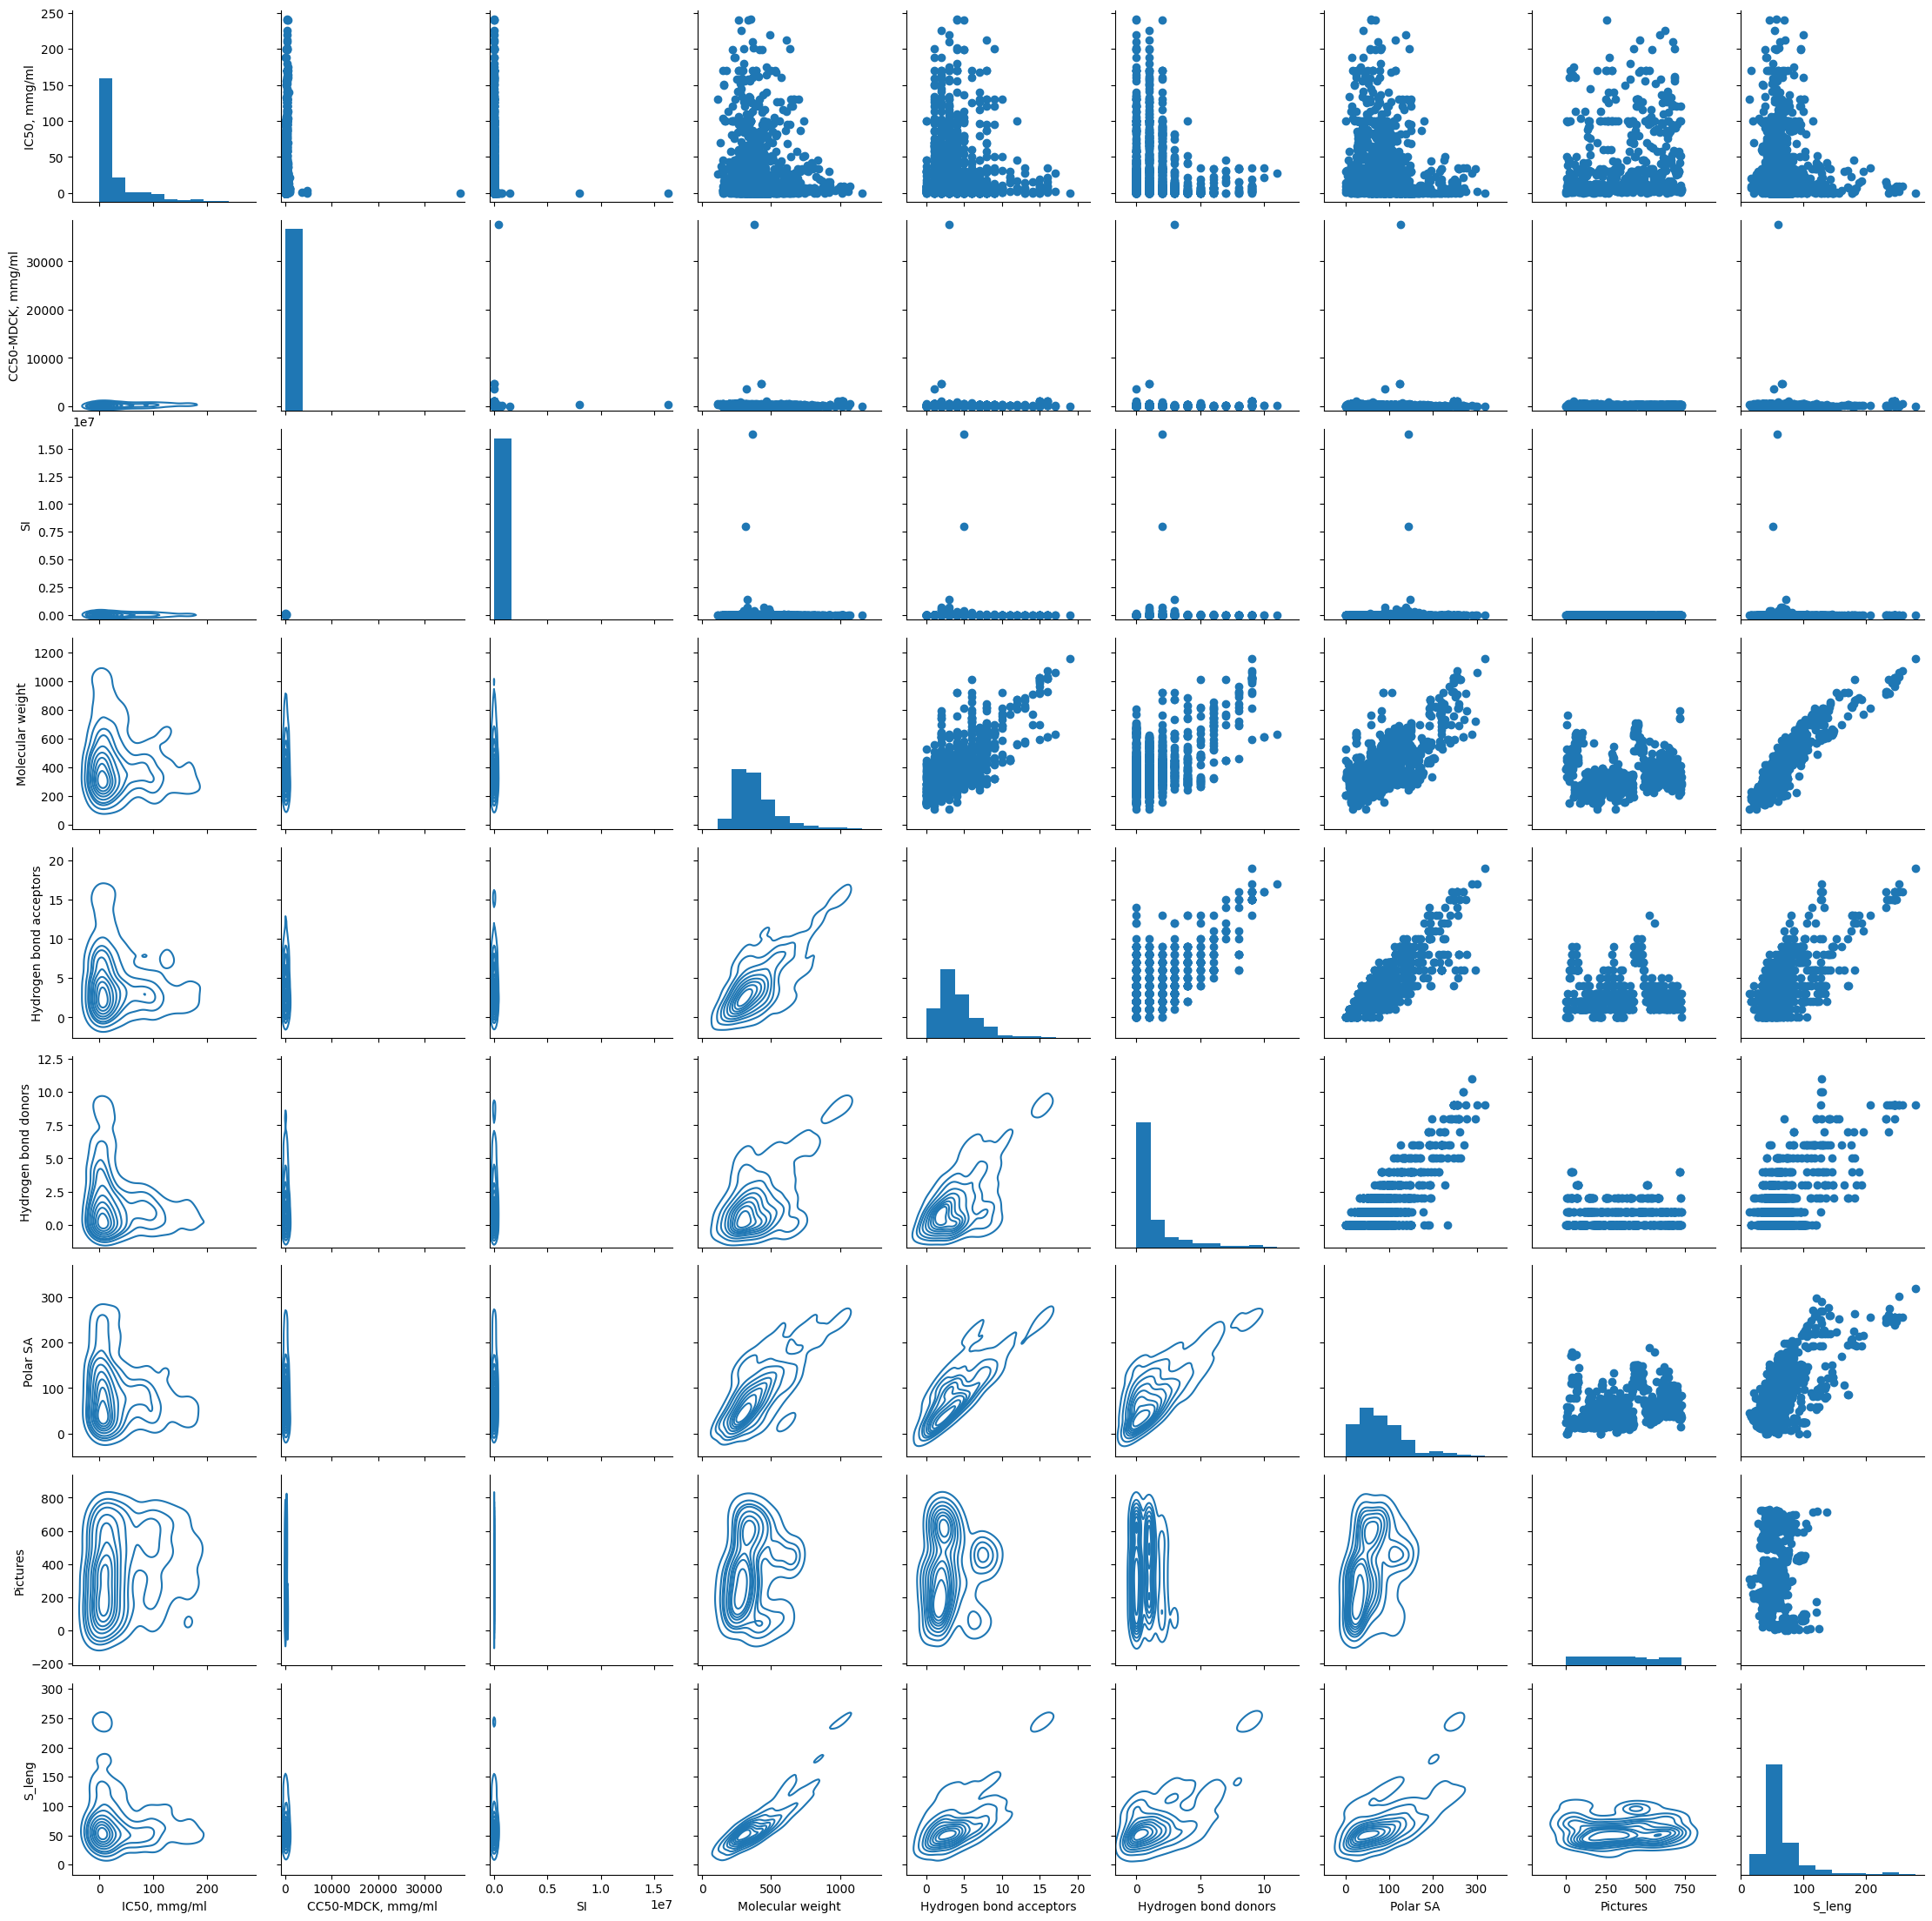

In [98]:
g = sns.PairGrid(df)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

<Axes: xlabel='Molecular weight', ylabel='S_leng'>

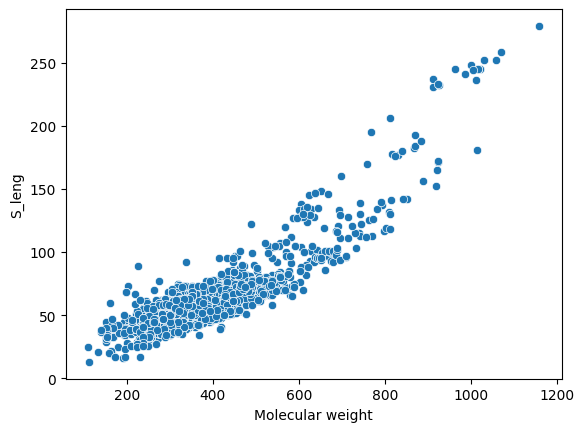

In [99]:
sns.scatterplot(data = df, x = 'Molecular weight', y = 'S_leng')

<Axes: xlabel='S_leng', ylabel='Count'>

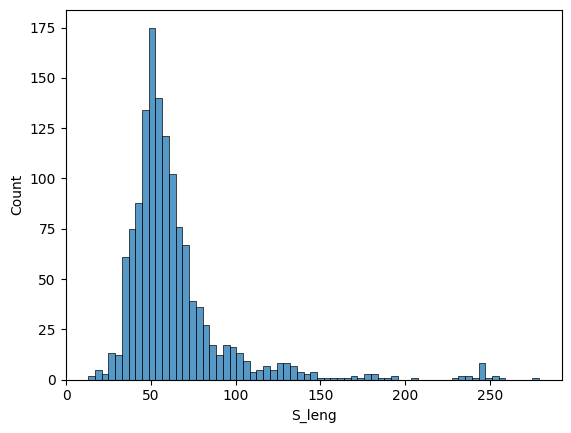

In [100]:
 sns.histplot(df['S_leng'])

In [101]:
missing_values = df.isnull().sum()
print("Пропущенные значения:\n", missing_values)

Пропущенные значения:
 Title                        0
IC50, mmg/ml                 0
CC50-MDCK, mmg/ml            0
SI                           0
Molecular weight             0
Hydrogen bond acceptors      0
Hydrogen bond donors         0
Polar SA                     0
SMILES                       0
Pictures                   731
S_leng                       0
dtype: int64


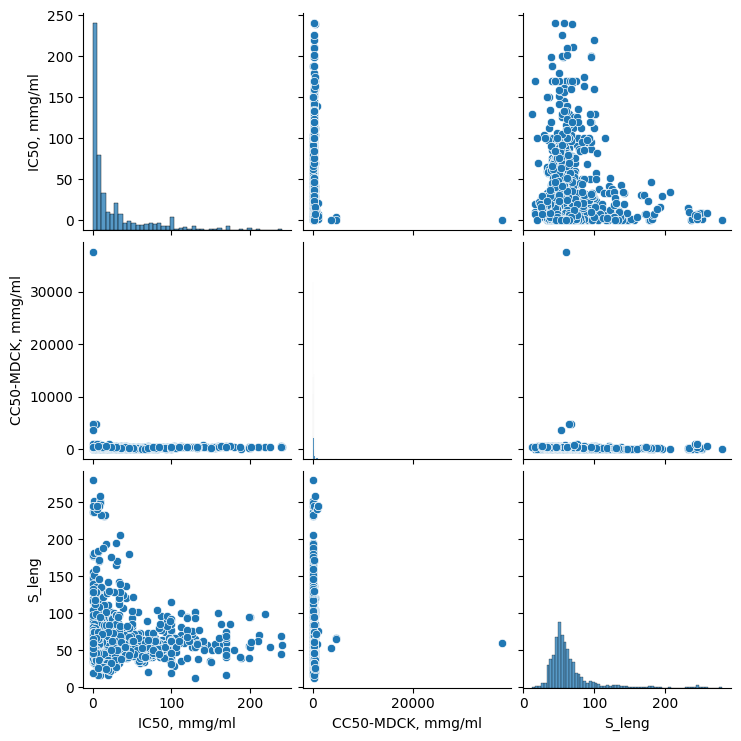

In [102]:
columns = ['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'S_leng']
sns.pairplot(df[columns])
plt.show()

Text(0, 0.5, 'CC50-MDCK, mmg/ml')

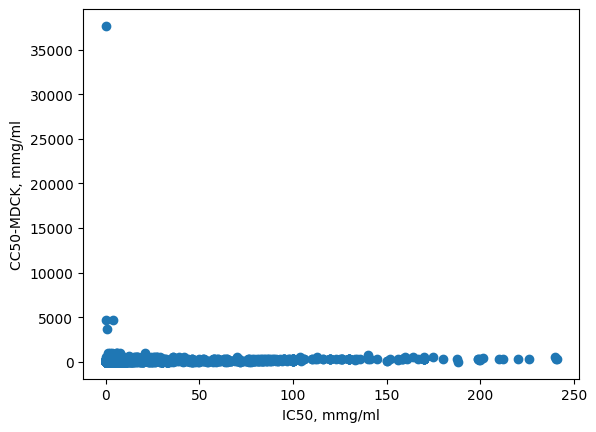

In [103]:
plt.figure()
plt.scatter(df['IC50, mmg/ml'], df['CC50-MDCK, mmg/ml'])
plt.xlabel('IC50, mmg/ml')
plt.ylabel('CC50-MDCK, mmg/ml')

In [104]:
df_v = df[['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight', 'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'S_leng']]
df_v = df_v[df_v.SI < 500]
df_v = df_v[df_v.S_leng < 140]
df_v.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,30.219915,134.692818,24.946650,370.388862,3.549342,1.138158,73.809178,58.503289
std,42.993633,140.702416,55.140339,125.158065,2.432131,1.514481,46.704559,20.389540
min,0.004219,0.031928,0.036161,110.157000,0.000000,0.000000,0.000000,13.000000
25%,3.000000,27.375000,2.156667,281.398000,2.000000,0.000000,38.690000,46.000000
50%,10.100000,76.450000,5.548171,345.372000,3.000000,1.000000,66.760000,54.000000
75%,35.600000,277.750000,22.250000,433.429750,4.000000,2.000000,99.330000,65.000000
max,240.800000,1039.000000,499.500000,812.925000,17.000000,11.000000,296.980000,139.000000


In [105]:
df.corr()

<ipython-input-105-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures,S_leng
"IC50, mmg/ml",1.000000,0.027230,-0.031923,-0.040996,-0.055240,-0.125537,-0.090265,0.210424,-0.061685
"CC50-MDCK, mmg/ml",0.027230,1.000000,0.022790,0.005809,-0.007622,0.017259,0.017636,-0.029559,0.015982
SI,-0.031923,0.022790,1.000000,-0.009195,0.011014,0.015462,0.051275,-0.110913,-0.007642
Molecular weight,-0.040996,0.005809,-0.009195,1.000000,0.717010,0.543387,0.748460,0.157575,0.882546
Hydrogen bond acceptors,-0.055240,-0.007622,0.011014,0.717010,1.000000,0.660581,0.819320,0.087219,0.690128
Hydrogen bond donors,-0.125537,0.017259,0.015462,0.543387,0.660581,1.000000,0.767756,-0.028862,0.629555
Polar SA,-0.090265,0.017636,0.051275,0.748460,0.819320,0.767756,1.000000,0.283871,0.681139
Pictures,0.210424,-0.029559,-0.110913,0.157575,0.087219,-0.028862,0.283871,1.000000,0.019205
S_leng,-0.061685,0.015982,-0.007642,0.882546,0.690128,0.629555,0.681139,0.019205,1.000000


<ipython-input-106-43e13db4cca3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)


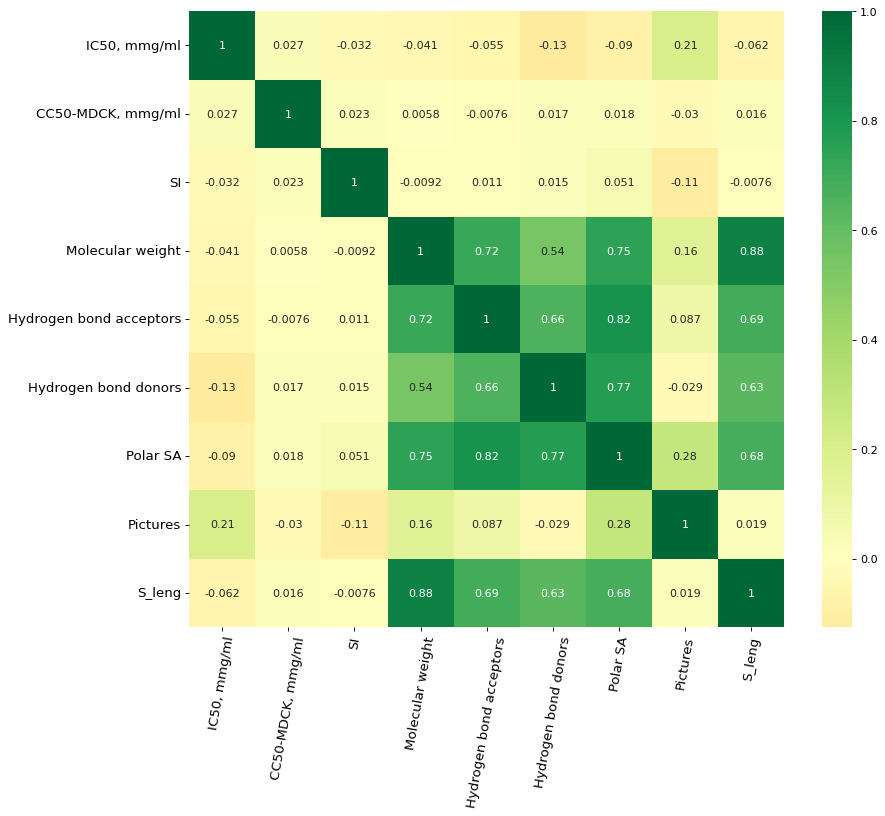

In [106]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.xticks(fontsize=12, rotation = 80)
plt.yticks(fontsize=12)
plt.show()

Vectorizer

In [107]:
PandasTools.AddMoleculeColumnToFrame(df, "SMILES", "Molecule")
df[["SMILES","Molecule"]]

[09:21:33] Conflicting single bond directions around double bond at index 55.
[09:21:33]   BondStereo set to STEREONONE and single bond directions set to NONE.
/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x78c6de450dd0>
1,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x78c6de4511c0>
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x78c6de451070>
3,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x78c6de451380>
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x78c6de4512a0>
...,...,...
1463,CCCCCCCc1c(OC)c(C)c(=O)oc1,<rdkit.Chem.rdchem.Mol object at 0x78c6dd98e570>
1464,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,<rdkit.Chem.rdchem.Mol object at 0x78c6dd98e5e0>
1465,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,<rdkit.Chem.rdchem.Mol object at 0x78c6dd98e650>
1466,c1ccc(C([O-])=O)c(c1C([O-])=O)-c(c2)ccc(c23)cc...,<rdkit.Chem.rdchem.Mol object at 0x78c6dd98e6c0>


In [108]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-vunrwnjv
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-vunrwnjv
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done


In [109]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df.Molecule.values)


In [110]:
y = df['IC50, mmg/ml'].values.reshape((-1,1))
# X = df.Molecule.values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# #Normalizing output using standard scaling
# scaler = StandardScaler()
# y_train = scaler.fit_transform(y_train)
# y_test = scaler.transform(y_test)
# y_validation = scaler.transform(y_validation)


In [111]:
y.shape

(1353, 1)

In [112]:
y = df['IC50, mmg/ml'].values.reshape((-1,1))
X = smivec.transform(df.Molecule.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)


PCA

Random Forest

In [113]:
from statsmodels.multivariate.factor import Factor

In [114]:
mas = []
for x in df['IC50, mmg/ml']:
  if (x < 8):
      mas.append(0)
  elif (8 <= x <= 250):
    mas.append(1)
  else:
    mas.append(2)
df['y'] = mas

<ipython-input-114-aa5823919818>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = mas


In [115]:
mas2 = []
for x in df['CC50-MDCK, mmg/ml']:
  if (x >= 8):
      mas2.append(0)
  else:
      mas2.append(1)
df['z'] = mas2

<ipython-input-115-7de5eb2a2519>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z'] = mas2


,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng,Molecule,y,z
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0,35,,0,0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0,35,,0,0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41,,1,0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0,39,,1,0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44,,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,CHEMBL4251117,7.3,530.6,72.684932,238.330,3,0,39.44,CCCCCCCc1c(OC)c(C)c(=O)oc1,NaN,26,,0,0
1464,CHEMBL4217515,3.8,4733.9,1245.763158,427.417,2,1,124.74,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,NaN,67,,0,0
1465,CHEMBL4205814,0.3,4733.9,15779.666667,427.417,2,1,124.74,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,NaN,65,,0,0
1466,CHEMBL4212064,0.7,3662.8,5232.571429,320.304,1,0,89.49,c1ccc(C([O-])=O)c(c1C([O-])=O)-c(c2)ccc(c23)cc...,NaN,53,,0,0

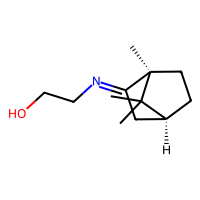
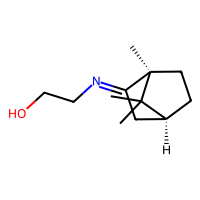
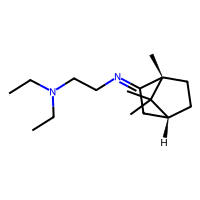
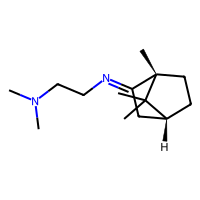
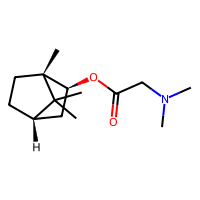
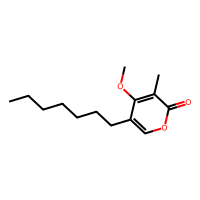
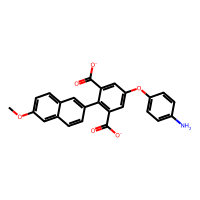
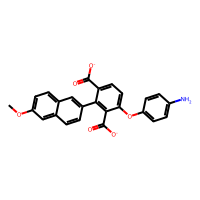
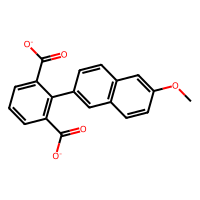
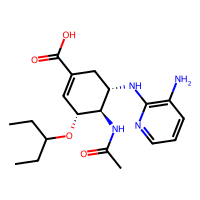

In [116]:
df

In [117]:
c = 0
v = 0
for i in df['IC50, mmg/ml']:
  if i < 8:
    c += 1
  elif 8 <= i <= 250:
    v += 1
print(c)
print(v)
print(1303 - c - v)

640
713
-50


In [118]:
df['IC50, mmg/ml'].describe()

count    1353.000000
mean       27.518646
std        41.628662
min         0.000010
25%         2.200000
50%         8.800000
75%        33.000000
max       240.800000
Name: IC50, mmg/ml, dtype: float64

#Сравнение моделей

**RandomForestClassifier**

In [119]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Функция для векторизации химических формул с использованием RDKit
def vectorize_formula(formula):
    mol = Chem.MolFromSmiles(formula)  # Преобразование формулы в молекулу с помощью SMILES
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)  # Генерация битового отпечатка молекулы
        return list(fingerprint)
    else:
        return [0] * 2048  # Возврат нулевого вектора в случае ошибки

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['y'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)


print("a", arr[0:10:1])
print(y)

clf = RandomForestClassifier(n_estimators=40, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")




[09:21:42] Conflicting single bond directions around double bond at index 55.
[09:21:42]   BondStereo set to STEREONONE and single bond directions set to NONE.


a [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 




RandomForestRegressor

In [120]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Функция для векторизации химических формул с использованием RDKit
def vectorize_formula(formula):
    mol = Chem.MolFromSmiles(formula)  # Преобразование формулы в молекулу с помощью SMILES
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)  # Генерация битового отпечатка молекулы
        return list(fingerprint)
    else:
        return [0] * 2048  # Возврат нулевого вектора в случае ошибки

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values

arr = []

for i in aaaaaa:
  arr.append(i)

y = df['IC50, mmg/ml'].values.reshape((-1,1))

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)


print("a", arr[0:10:1])
print(y)

clr = RandomForestRegressor(n_estimators=100, random_state=42)
clr.fit(x_train, y_train)

y_pred = clr.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")



[09:21:44] Conflicting single bond directions around double bond at index 55.
[09:21:44]   BondStereo set to STEREONONE and single bond directions set to NONE.


a [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-120-c5f3b5fad150>:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr.fit(x_train, y_train)


Среднеквадратичная ошибка: 1746.0368523492782


Линейная Регрессия

In [121]:
# Разбить исходную выборку на обучающую и тестовую (70% первых строк включить в обучающую выборку, оставшиеся строки – в тестовую)
# Обучить простейшую линейную регрессионную модель со свободным членом методом наименьших квадратов

from sklearn.linear_model import LinearRegression


# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['IC50, mmg/ml'].values.reshape((-1,1))

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# creating a regression model
model = LinearRegression()
model.fit(x_train, y_train)

# y_train_pred = model.predict(x_train)
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")


[09:22:04] Conflicting single bond directions around double bond at index 55.
[09:22:04]   BondStereo set to STEREONONE and single bond directions set to NONE.


Среднеквадратичная ошибка: 1.6645277825740624e+25


KNeighborsClassifier

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values

arr = []

for i in aaaaaa:
  arr.append(i)

y = df['y'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Создание модели k-NN с k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Обучение модели на обучающей выборке
knn.fit(x_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = knn.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:07] Conflicting single bond directions around double bond at index 55.
[09:22:07]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.7492625368731564
Среднеквадратичная ошибка: 0.25073746312684364


*Метод* опорных векторов

In [123]:
from sklearn.svm import SVC

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['y'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# # Нормализация данных
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# Создание модели SVM с линейным ядром
svm_classifier = SVC(kernel='linear')

# Обучение модели на обучающей выборке
svm_classifier.fit(x_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = svm_classifier.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:08] Conflicting single bond directions around double bond at index 55.
[09:22:08]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.7522123893805309
Среднеквадратичная ошибка: 0.24778761061946902


Нейронная сеть

In [124]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler


# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['y'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Нормализация данных
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



# Создание нейронной сети
model = keras.Sequential([
    keras.layers.Input(shape=(2048,)),  # Входной слой с 4 признаками
    keras.layers.Dense(200, activation='relu'),  # Скрытый слой с 64 нейронами и функцией активации ReLU
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Выходной слой с 3 нейронами (по количеству классов) и функцией активации softmax
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

# Оценка качества модели на тестовой выборке
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:11] Conflicting single bond directions around double bond at index 55.
[09:22:11]   BondStereo set to STEREONONE and single bond directions set to NONE.


Epoch 1/50
26/26 [==============================] - 1s 9ms/step - loss: 0.6508 - accuracy: 0.6621
Epoch 2/50
26/26 [==============================] - 0s 8ms/step - loss: 0.2344 - accuracy: 0.9088
Epoch 3/50
26/26 [==============================] - 0s 8ms/step - loss: 0.1547 - accuracy: 0.9383
Epoch 4/50
26/26 [==============================] - 0s 8ms/step - loss: 0.1274 - accuracy: 0.9482
Epoch 5/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0984 - accuracy: 0.9556
Epoch 6/50
26/26 [==============================] - 0s 8ms/step - loss: 0.1048 - accuracy: 0.9531
Epoch 7/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0725 - accuracy: 0.9642
Epoch 8/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0709 - accuracy: 0.9679
Epoch 9/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0573 - accuracy: 0.9655
Epoch 10/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0504 - accuracy: 0.9741
Epoch 11/50
26/26 [

Градиентный бустинг

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values

arr = []

for i in aaaaaa:
  arr.append(i)

y = df['y'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Создание модели градиентного бустинга с деревьями решений
gboost_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Обучение модели на обучающей выборке
gboost_classifier.fit(x_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = gboost_classifier.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:35] Conflicting single bond directions around double bond at index 55.
[09:22:35]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.7522123893805309
Среднеквадратичная ошибка: 0.24778761061946902


In [126]:
import xgboost as xgb

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['y'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Создание DMatrix (оптимизированный формат данных для XGBoost)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Определение параметров модели XGBoost
params = {
    'objective': 'multi:softmax',  # Задача классификации с множеством классов
    'num_class': 3,  # Количество классов
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'mlogloss'
}

# Обучение модели XGBoost
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Делаем предсказания на тестовой выборке
y_pred = model.predict(dtest)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:41] Conflicting single bond directions around double bond at index 55.
[09:22:41]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.7610619469026548
Среднеквадратичная ошибка: 0.23893805309734514


Градиентный бустинг для регрессии


In [127]:
import xgboost as xgb

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['IC50, mmg/ml'].values.reshape((-1,1))

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)


# Создание DMatrix (оптимизированный формат данных для XGBoost)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Определение параметров модели XGBoost для регрессии
params = {
    'objective': 'reg:squarederror',  # Задача регрессии
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'rmse'  # Корень из средней квадратичной ошибки
}

# Обучение модели XGBoost
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Делаем предсказания на тестовой выборке
y_pred = model.predict(dtest)

# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:43] Conflicting single bond directions around double bond at index 55.
[09:22:43]   BondStereo set to STEREONONE and single bond directions set to NONE.


Среднеквадратичная ошибка: 1699.505901800875


Регрессия с поддержкой векторов

In [128]:
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['IC50, mmg/ml'].values.reshape((-1,1))

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Создание модели Support Vector Regression
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Обучение модели на данных
svr_rbf.fit(x_train, y_train)

# Предсказание с использованием модели
y_pred = svr_rbf.predict(x_test)

# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:22:45] Conflicting single bond directions around double bond at index 55.
[09:22:45]   BondStereo set to STEREONONE and single bond directions set to NONE.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Среднеквадратичная ошибка: 1710.6862428630798


Предсказание CC50

**RandomForestClassifier**





In [129]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Функция для векторизации химических формул с использованием RDKit
def vectorize_formula(formula):
    mol = Chem.MolFromSmiles(formula)  # Преобразование формулы в молекулу с помощью SMILES
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)  # Генерация битового отпечатка молекулы
        return list(fingerprint)
    else:
        return [0] * 2048  # Возврат нулевого вектора в случае ошибки

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values

arr = []

for i in aaaaaa:
  arr.append(i)

y = df['z'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)



clf = RandomForestClassifier(n_estimators=40, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")




[09:22:49] Conflicting single bond directions around double bond at index 55.
[09:22:49]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.9233038348082596
Среднеквадратичная ошибка: 0.07669616519174041


**RandomForestRegressor**

In [130]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Функция для векторизации химических формул с использованием RDKit
def vectorize_formula(formula):
    mol = Chem.MolFromSmiles(formula)  # Преобразование формулы в молекулу с помощью SMILES
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)  # Генерация битового отпечатка молекулы
        return list(fingerprint)
    else:
        return [0] * 2048  # Возврат нулевого вектора в случае ошибки

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['CC50-MDCK, mmg/ml'].values.reshape((-1,1))

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)




clr = RandomForestRegressor(n_estimators=100, random_state=42)
clr.fit(x_train, y_train)

y_pred = clr.predict(x_test)




mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")



[09:22:51] Conflicting single bond directions around double bond at index 55.
[09:22:51]   BondStereo set to STEREONONE and single bond directions set to NONE.
<ipython-input-130-2b2fd58674e8>:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr.fit(x_train, y_train)


Среднеквадратичная ошибка: 211725.0009802636


**KNeighborsClassifier**

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values

arr = []

for i in aaaaaa:
  arr.append(i)

y = df['z'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Создание модели k-NN с k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Обучение модели на обучающей выборке
knn.fit(x_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = knn.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:23:06] Conflicting single bond directions around double bond at index 55.
[09:23:06]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.9174041297935103
Среднеквадратичная ошибка: 0.08259587020648967


*Метод* опорных векторов

In [132]:
from sklearn.svm import SVC

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['z'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)


# Создание модели SVM с линейным ядром
svm_classifier = SVC(kernel='linear')

# Обучение модели на обучающей выборке
svm_classifier.fit(x_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = svm_classifier.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:23:08] Conflicting single bond directions around double bond at index 55.
[09:23:08]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.911504424778761
Среднеквадратичная ошибка: 0.08849557522123894


Градиентный бустинг

In [133]:
from sklearn.ensemble import GradientBoostingClassifier

# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values

arr = []

for i in aaaaaa:
  arr.append(i)

y = df['z'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Создание модели градиентного бустинга с деревьями решений
gboost_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Обучение модели на обучающей выборке
gboost_classifier.fit(x_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = gboost_classifier.predict(x_test)

# Оценка качества модели (точность)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:23:10] Conflicting single bond directions around double bond at index 55.
[09:23:10]   BondStereo set to STEREONONE and single bond directions set to NONE.


Точность модели: 0.9233038348082596
Среднеквадратичная ошибка: 0.07669616519174041


Нейронная сеть

In [134]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler


# Применяем функцию векторизации к формулам
aaaaaa = df['SMILES'].apply(vectorize_formula)
aaaaaa = aaaaaa.values


arr = []

for i in aaaaaa:
  arr.append(i)

y = df['z'].values

x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Нормализация данных
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Создание нейронной сети
model = keras.Sequential([
    keras.layers.Input(shape=(2048,)),  # Входной слой с 4 признаками
    keras.layers.Dense(200, activation='relu'),  # Скрытый слой с 64 нейронами и функцией активации ReLU
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Выходной слой с 3 нейронами (по количеству классов) и функцией активации softmax
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

# Оценка качества модели на тестовой выборке
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Точность модели: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

[09:23:16] Conflicting single bond directions around double bond at index 55.
[09:23:16]   BondStereo set to STEREONONE and single bond directions set to NONE.


Epoch 1/50
26/26 [==============================] - 1s 8ms/step - loss: 0.3389 - accuracy: 0.8853
Epoch 2/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0871 - accuracy: 0.9593
Epoch 3/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0346 - accuracy: 0.9914
Epoch 4/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9914
Epoch 5/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0163 - accuracy: 0.9951
Epoch 6/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0139 - accuracy: 0.9926
Epoch 7/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0135 - accuracy: 0.9914
Epoch 8/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0128 - accuracy: 0.9938
Epoch 9/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0137 - accuracy: 0.9938
Epoch 10/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0125 - accuracy: 0.9914
Epoch 11/50
26/26 [